## 1. 패키지 설치

In [ ]:
## 패키지 설치
import glob
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import math
import copy

## 2. 노원, 종로구 데이터 합치기
### 아래 파일 경로 안에 대회에서 제공한 환경기상데이터 csv 파일들이 다 들어있어야 함.

In [2]:
## 노원, 종로구 데이터 합치기
# 아래 파일 경로 안에 대회에서 제공한 환경기상데이터 csv 파일들이 다 들어있어야 함.
path =r'C:\Users\korea\practice\환경기상데이터' 
allFiles = glob.glob(path + "/*.csv")
frame = pd.DataFrame()
finedust= []
for file_ in allFiles:
    data_frame=pd.read_csv(file_,index_col=None)
    finedust.append(data_frame)
    #list_.append(finedust)
finedust_concat=pd.concat(finedust,axis=0,ignore_index=True)


In [3]:
## 노원, 종로구에 구, 동 변수 추가. dong= 각 파일마다 변수
# 우선, 측정기번호, 측정기위치, 행정구, 행정동 변수가 있는 파일을 가져오자.
# 환경기상데이터 csv파일과 다른 경로에 있어야 함. 
envi_gu_dong=pd.read_csv(r'C:\Users\korea\practice\environment_gu_dong.csv',encoding='utf-8')

#그리고 serial을 기준으로 merge하자.
finedust=pd.merge(finedust_concat,envi_gu_dong,on='serial')


In [4]:
# 이상한 변수 Unnamed: 10 삭제
finedust = finedust.drop('Unnamed: 10',axis=1)

## 3. 결측치, 극단치 제어 및 각종 전처리

In [5]:
# 실내 측정기 있는지 확인. 아예 없으면, co2와 vocs는 삭제 가능
# flag, co2, vocs 삭제 근거 찾기
pd.value_counts(finedust['flag'].values, sort=False)
# 실내측정기(flag)는 없는 것 같다. 없거나 -999. 

 1      22467385
-999      723815
dtype: int64

In [6]:
# 실내에서만 측정되는 co2와 vocs의 빈도도 확인해보자.
pd.value_counts(finedust['co2'].values, sort=False)
# 역시 삭제하자.

-9999    22467385
-999       723815
dtype: int64

In [7]:
pd.value_counts(finedust['vocs'].values, sort=False)
# 이 변수도 삭제하자.

-9999    22467385
-999       723815
dtype: int64

In [8]:
# 위에서 언급한 3개 변수(flag,co2,vocs) 삭제
finedust=finedust.drop(['flag','co2','vocs'],axis=1)

In [9]:
## 본격적으로 결측치와 극단치 제어.
# 먼저, 도렴동(V01o1610468)의 관측치를 제거하자. 도렴동 csv 파일을 열어보니 데이터가 모두 결측.
# register_date 필요 없음. 2018년 4월 이전에 다 등록. 해당 변수 삭제. 
finedust = finedust[finedust.serial!='V01o1610468']
finedust = finedust.drop('register_date',axis=1)



In [10]:
# 음의 극단치들 모두 결측으로 처리하기
finedust1 = copy.deepcopy(finedust)

finedust1.pm10.loc[finedust1.pm10<0] = None
finedust1.noise.loc[finedust1.noise<0] = None
finedust1.temp.loc[finedust1.temp<-40] = None
finedust1.humi.loc[finedust1.humi<0] = None
finedust1.pm25.loc[finedust1.pm25<0] = None


C:\Users\korea\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [11]:
# 양의 극단치 pm25 없애주기. IQR*3 + Q3 기준. 
# 참고로 온도, 습도, 바람은 양의 극단치 발견 X
#np.percentile(x, 75)  # 3사분위 수.
# boxplot에서 최대값은 3분위수 + 1.5 * IQR
finedust2=finedust1.reset_index(inplace=False)

# pm25의 3분위수를 계산하자.
finedust3_pm25 = finedust2['pm25'].dropna() # 결측이 있으면 percentile 못 쓴다. 
# 계산비용으로 인해 IQR * 3 + Q3 적용. 
iqr_pm25 = (np.percentile(finedust3_pm25,75)-np.percentile(finedust3_pm25,25))*3 + np.percentile(finedust3_pm25,75) 
[iqr_pm25,sum(finedust3_pm25>=iqr_pm25)] 
# 83 초과는 내 검사기에 들어갈 것이고 대략 120만개.. 

pm25_outlier=finedust3_pm25[finedust3_pm25>=iqr_pm25] # iqr max 넘은 것들만 거르기
pm25_outlier_index= pm25_outlier.index.tolist() # 인덱스들을 리스트로 만들고.. 
[iqr_pm25,sum(finedust3_pm25>=iqr_pm25)] 

# 관측치의 앞 5개 관측치보다 너무 다르면, 결측으로 처리하는 코드
for i in pm25_outlier_index:
    bound=range(i-5,i)
    before_pm25=finedust2.iloc[list(bound),6]
    if before_pm25.isnull().all()==True: # i번째 전 5개 관측이 모두 결측이면 넘어가기
        continue
    if max(filter(lambda v: v is not None, before_pm25))*10 <= finedust2.pm25[i]:
        finedust2.pm25[i] = None # 6번째가 pm25. 앞 5개의 최대값 * 10이 지금 값보다 작다면 그건 양의 결측치


C:\Users\korea\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [13]:
###양의 극단치 pm10 없애주기. IQR*3 + Q3

finedust3_pm10 = finedust2['pm10'].dropna() # 결측이 있으면 percentile 못 쓴다. 
iqr_pm10 = (np.percentile(finedust3_pm10,75)-np.percentile(finedust3_pm10,25))*4 + np.percentile(finedust3_pm10,75) 
# 계산비용으로 인해 IQR * 3 + Q3 적용. 
[iqr_pm10,sum(finedust3_pm10>=iqr_pm10)] 
# 83 초과는 내 검사기에 들어갈 것이고 대략 120만개.. 

pm10_outlier=finedust3_pm10[finedust3_pm10>=iqr_pm10] # iqr max 넘은 것들만 거르기
pm10_outlier_index= pm10_outlier.index.tolist() # 인덱스들을 리스트로 만들고.. 
[iqr_pm10,sum(finedust3_pm10>=iqr_pm10)] 

for i in pm10_outlier_index:
    bound=range(i-5,i)
    before_pm10=finedust2.iloc[list(bound),6]
    if before_pm10.isnull().all()==True: # i번째 전 5개 관측이 모두 결측이면 넘어가기
        continue
    if max(filter(lambda v: v is not None, before_pm10))*10 <= finedust2.pm10[i]:
        finedust2.pm10[i] = None # 6번째가 pm10. 앞 5개의 최대값 * 10이 지금 값보다 작다면 그건 양의 결측치

C:\Users\korea\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [14]:
# 영천동 277(천연동) -> 교남동 , 태평로1가 68-2(명동) -> 종로 1,2,3,4가동
finedust2.dong[finedust2.spot=='영천동 277']='교남동'
finedust2.dong[finedust2.spot=='태평로1가 68-2']='종로 1,2,3,4가동'


C:\Users\korea\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\korea\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
finedust2.isnull().sum()
# isnull().all()로 했을 때. 결측이 약 1만개, 2만개 증가.

index          0
tm             0
serial         0
pm10      339938
noise     289995
temp      364725
humi      364725
pm25      325697
spot           0
gu             0
dong           0
dtype: int64

In [16]:
# 행정동 띄어쓰기 없애기
finedust2.set_index('index',inplace=True)
finedust2.dong.loc[finedust2.dong=='종로 1,2,3,4가동'] = '종로1,2,3,4가동' # 행정동에 공백 없애기
finedust2.head()

,tm,serial,pm10,noise,temp,humi,pm25,spot,gu,dong
index,,,,,,,,,,
446400,201805070000,V10O1610102,NaN,NaN,NaN,NaN,NaN,하계동 251,1,하계1동
446401,201805070001,V10O1610102,NaN,NaN,NaN,NaN,NaN,하계동 251,1,하계1동
446402,201805070002,V10O1610102,NaN,NaN,NaN,NaN,NaN,하계동 251,1,하계1동
446403,201805070003,V10O1610102,NaN,NaN,NaN,NaN,NaN,하계동 251,1,하계1동
446404,201805070004,V10O1610102,NaN,NaN,NaN,NaN,NaN,하계동 251,1,하계1동


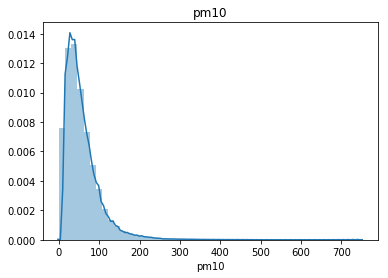

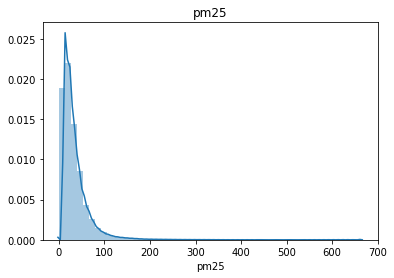

In [17]:
## 이제, 주요변수인 pm10과 pm25부터 분포를 살펴보자.
# 2가지 주요변수는 숫자형임을 주목하자. 
numerical_feature=['pm10','pm25']

for col in numerical_feature:
    sns.distplot(finedust2.loc[finedust2[col].notnull(), col])
    plt.title(col)
    plt.show()
# 두 변수 모두 극단치가 많은 분포. 오른쪽으로 꼬리가 길다.

In [18]:
# 세종로 100 관측소가 여러 개여서 평균을 통해서 하나로 합치기.
finedust_temp = finedust2.loc[finedust2.spot=='세종로 100']
grouped1=finedust_temp['pm25'].groupby(finedust_temp['tm'])
grouped2=finedust_temp['pm10'].groupby(finedust_temp['tm'])
grouped3=finedust_temp['noise'].groupby(finedust_temp['tm'])
grouped4=finedust_temp['temp'].groupby(finedust_temp['tm'])
grouped5=finedust_temp['humi'].groupby(finedust_temp['tm'])

# 그룹화한 것들을 평균 때리자.
grouped1.mean()
grouped2.mean()
grouped3.mean()
grouped4.mean()
grouped5.mean()

# 바로 위의 시리즈들을 합쳐서 데이터프레임으로 만들자
grouped_temp = pd.concat([grouped1.mean(),grouped2.mean(),grouped3.mean(),grouped4.mean(),grouped5.mean()],axis=1)

# tm 변수 살리고, spot 변수 추가 
grouped_temp=grouped_temp.reset_index()
grouped_temp['spot'] = '세종로 100'
grouped_temp['dong'] = '종로1,2,3,4가동'
grouped_temp['gu'] = 0
grouped_temp['serial'] = 'sejong'

## 이제 finedust2에서 세종로 100인 것을 삭제하고 grouped_temp를 가져오자.
finedust3 = finedust2.loc[finedust2.spot != '세종로 100',:]

finedust3 = pd.concat([finedust3,grouped_temp],ignore_index=True, sort=False)


In [19]:
# 관측소들을 행정동 기준으로 합치기 
############## 관측소들을 행정동 기준으로 합치기#################
#################################################################
finedust4 = finedust3.iloc[0:2,:] # 한 행 데이터프레임에 변수명 가져오는 효율적인 방법. 나중엔 1~2행 지워줘야! 
finedust4 = finedust4.drop(['serial','spot'],axis=1) #

# 동 리스트 
dong_list = finedust3.dong.value_counts().index.tolist()

# 동별로 합치기. 
for i in dong_list:
    finedust_temp = finedust3.loc[finedust3.dong == i]
    grouped1=finedust_temp['pm25'].groupby(finedust_temp['tm'])
    grouped2=finedust_temp['pm10'].groupby(finedust_temp['tm'])
    grouped3=finedust_temp['noise'].groupby(finedust_temp['tm'])
    grouped4=finedust_temp['temp'].groupby(finedust_temp['tm'])
    grouped5=finedust_temp['humi'].groupby(finedust_temp['tm'])
    grouped6=finedust_temp['gu'].groupby(finedust_temp['tm'])
   
    # 그룹화한 것들을 평균 때리자.
    grouped1.mean()
    grouped2.mean()
    grouped3.mean()
    grouped4.mean()
    grouped5.mean()
    grouped6.mean()
    
    # 바로 위의 시리즈들을 합쳐서 데이터프레임으로 만들자
    grouped_temp = pd.concat([grouped1.mean(),grouped2.mean(),grouped3.mean(),grouped4.mean(),grouped5.mean(),grouped6.mean()],axis=1)
    
    # tm 변수 살리고, dong 변수 추가 
    grouped_temp=grouped_temp.reset_index()
    grouped_temp['dong'] = i
    finedust4 = pd.concat([finedust4,grouped_temp],axis=0,ignore_index=True)

# for 루프 다 돌리고 1,2행 삭제
finedust4 = finedust4.iloc[2:finedust4.shape[0],:]


C:\Users\korea\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [20]:
# 없는 행정동 보정하기: 주변 측정소의 평균 or 대치
# 우선 없는 행정동과 spot에 대한 딕셔너리를 만들자
update_dong = {'숭인1동':['창신동 17-9','숭인동 227-2'],
              '창신2동':['창신동 17-9','창신동 170-3'],
              '상계8동':['상계동 1102-17','상계동 692-2'],
              '상계9동':['상계동 397-12','상계동 456-16','상계2동 407-39'],
              '월계2동':['하계동 280','월계동 411-53'],
              '중계1동':['중계동 364-17','상계동 1281'],
              '중계4동':['중계동 364-17','상계동 1281','상계5동 156-203'],
              '하계2동':['하계동 280','공릉동 385-5'],
               '삼청동':['세종로 1-57','가회동 177-18','재동 95-2'],
               '무악동': ['영천동 277']
              }

# 동별로 합치기.
finedust6 = copy.deepcopy(finedust3)

for key,val in update_dong.items():
    finedust_temp = finedust6.loc[finedust6['spot'].apply(lambda x: x in val)]
    grouped1=finedust_temp['pm25'].groupby(finedust_temp['tm'])
    grouped2=finedust_temp['pm10'].groupby(finedust_temp['tm'])
    grouped3=finedust_temp['noise'].groupby(finedust_temp['tm'])
    grouped4=finedust_temp['temp'].groupby(finedust_temp['tm'])
    grouped5=finedust_temp['humi'].groupby(finedust_temp['tm'])
    grouped6=finedust_temp['gu'].groupby(finedust_temp['tm'])
   
    # 그룹화한 것들을 평균 때리자.
    grouped1.mean()
    grouped2.mean()
    grouped3.mean()
    grouped4.mean()
    grouped5.mean()
    grouped6.mean()
    
    # 바로 위의 시리즈들을 합쳐서 데이터프레임으로 만들자
    grouped_temp = pd.concat([grouped1.mean(),grouped2.mean(),grouped3.mean(),grouped4.mean(),grouped5.mean(),grouped6.mean()],axis=1)
    
    # tm 변수 살리고, dong 변수 추가 
    grouped_temp=grouped_temp.reset_index()
    grouped_temp['dong'] = key
    finedust6 = pd.concat([finedust6,grouped_temp],axis=0,ignore_index=True)

finedust6 = finedust6.drop(['serial','spot'],axis=1) # serial, spot 변수 삭제 
finedust4 = pd.concat([finedust4,finedust6],axis=0) # 기존 행정동 + 없던 행정동 


C:\Users\korea\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [30]:
finedust4.head()

,dong,gu,humi,noise,pm10,pm25,temp,tm
2,"종로1,2,3,4가동",0,58.208333,53.041667,46.437500,24.395833,13.897917,201804010000
3,"종로1,2,3,4가동",0,58.250000,50.916667,46.833333,24.833333,13.895833,201804010001
4,"종로1,2,3,4가동",0,58.229167,52.875000,52.625000,27.645833,13.877083,201804010002
5,"종로1,2,3,4가동",0,58.395833,51.208333,46.604167,24.750000,13.893750,201804010003
6,"종로1,2,3,4가동",0,58.604167,52.229167,51.062500,26.979167,13.866667,201804010004


In [29]:
finedust4.to_csv('finedust4.csv')

In [2]:
# 날짜화 시킬 때 메모리에러 뜨기에 저장하고 껐다 켜서 시작하기
finedust4 = pd.read_csv('finedust4.csv')
finedust4 = finedust4.drop('Unnamed: 0',axis=1)
finedust4.head()

,dong,gu,humi,noise,pm10,pm25,temp,tm
0,"종로1,2,3,4가동",0,58.208333,53.041667,46.437500,24.395833,13.897917,201804010000
1,"종로1,2,3,4가동",0,58.250000,50.916667,46.833333,24.833333,13.895833,201804010001
2,"종로1,2,3,4가동",0,58.229167,52.875000,52.625000,27.645833,13.877083,201804010002
3,"종로1,2,3,4가동",0,58.395833,51.208333,46.604167,24.750000,13.893750,201804010003
4,"종로1,2,3,4가동",0,58.604167,52.229167,51.062500,26.979167,13.866667,201804010004


In [3]:
# tm 변수를 날짜화 시키고 인덱스로 만들어서 월별, 일별, 시간별 데이터 만들기
finedust5= copy.deepcopy(finedust4)
finedust5['tm']= finedust5['tm'].apply(str)
finedust5['tm'] = pd.to_datetime(finedust5['tm'])
finedust5.set_index('tm',inplace=True)


In [9]:
# finedust3 가져오기. 
finedust3 = pd.read_csv('finedust3.csv',encoding='euc-kr')
finedust3 = finedust3.drop('Unnamed: 0',axis=1)


In [10]:
finedust3.head(1)

,tm,serial,pm10,noise,temp,humi,pm25,spot,gu,dong
0,201805070000,V10O1610102,NaN,NaN,NaN,NaN,NaN,하계동 251,1,하계1동


In [13]:
finedust_month.head(1)

,dong,gu,humi,noise,pm10,pm25,temp
2018-04-30 00:00:00,"종로1,2,3,4가동",0.0,46.55255,53.270944,48.335996,24.81753,14.21468


## 4. 월별, 일별, 시간별 미세먼지 데이터 생성

In [11]:

############## 월별로 합치기 #################
#################################################################

finedust_month = finedust3.iloc[0:2,:] # 한 행 데이터프레임에 변수명 가져오는 효율적인 방법. 나중엔 1~2행 지워줘야! 
finedust_month = finedust_month.drop(['serial','spot'],axis=1) #

# 동 리스트 
dong_list = finedust4.dong.value_counts().index.tolist()
dong_list

# 우선, 월별로 합쳐보자.
for i in dong_list:
    finedust_temp = copy.deepcopy(finedust5)
    finedust_temp = finedust_temp.loc[finedust_temp.dong == i]
    finedust_temp = finedust_temp.resample(rule='M').mean()
    
    # 동 변수 넣어주기
    finedust_temp['dong'] = i
    finedust_month = pd.concat([finedust_month,finedust_temp],axis=0,ignore_index=False)

# for 루프 다 돌리고 1,2행 삭제
finedust_month = finedust_month.iloc[2:finedust_month.shape[0],:]
finedust_month = finedust_month.drop(['tm'],axis=1)


############## 일별로 합치기#################
#################################################################
finedust_day = finedust3.iloc[0:2,:] # 한 행 데이터프레임에 변수명 가져오는 효율적인 방법. 나중엔 1~2행 지워줘야! 
finedust_day = finedust_day.drop(['serial','spot'],axis=1) #

# 동별로 합치기. 
for i in dong_list:
    finedust_temp = copy.deepcopy(finedust5)
    finedust_temp = finedust_temp.loc[finedust_temp.dong == i]
    finedust_temp = finedust_temp.resample(rule='D').mean()
    
    # 동 변수 넣어주기
    finedust_temp['dong'] = i
    finedust_day = pd.concat([finedust_day,finedust_temp],axis=0,ignore_index=False)

# for 루프 다 돌리고 1,2행 삭제
finedust_day = finedust_day.iloc[2:finedust_day.shape[0],:]
finedust_day = finedust_day.drop(['tm'],axis=1)


############## 시간별로 합치기#################
#################################################################
finedust_hour = finedust3.iloc[0:2,:] # 한 행 데이터프레임에 변수명 가져오는 효율적인 방법. 나중엔 1~2행 지워줘야! 
finedust_hour = finedust_hour.drop(['serial','spot'],axis=1) #

# 동별로 합치기. 
for i in dong_list:
    finedust_temp = copy.deepcopy(finedust5)
    finedust_temp = finedust_temp.loc[finedust_temp.dong == i]
    finedust_temp = finedust_temp.resample(rule='H').mean()
    
    # 동 변수 넣어주기
    finedust_temp['dong'] = i
    finedust_hour = pd.concat([finedust_hour,finedust_temp],axis=0,ignore_index=False)

# for 루프 다 돌리고 1,2행 삭제
finedust_hour = finedust_hour.iloc[2:finedust_hour.shape[0],:]
finedust_hour = finedust_hour.drop(['tm'],axis=1)




C:\Users\korea\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

C:\Users\korea\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

C:\Users\korea\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [15]:
# index로 들어간 tm을 살리고
finedust_month=finedust_month.reset_index()
finedust_day=finedust_day.reset_index()
finedust_hour=finedust_hour.reset_index()


In [18]:
# index라는 이름을 tm으로 바꾸고. 
finedust_month.rename(columns = {'index':'tm'},inplace=True)
finedust_day.rename(columns = {'index':'tm'},inplace=True)
finedust_hour.rename(columns = {'index':'tm'},inplace=True)


In [19]:
finedust_month.head(1)

,tm,dong,gu,humi,noise,pm10,pm25,temp
0,2018-04-30,"종로1,2,3,4가동",0.0,46.55255,53.270944,48.335996,24.81753,14.21468


In [20]:
### 요일 변수 추가 . 0: 월요일~ 6: 일요일
finedust_day['yoil'] = finedust_day.tm.apply(lambda x : x.weekday())
finedust_hour['yoil'] = finedust_hour.tm.apply(lambda x : x.weekday())


In [21]:
# finedust2.dong.loc[finedust2.dong=='종로 1,2,3,4가동'] = '종로1,2,3,4가동'
# finedust_temp = finedust6.loc[finedust6['spot'].apply(lambda x: x in val)]
## 공휴일 변수 추가. 0이면 평일, 1이면 공휴일(공휴일,토,일). 
# finedust_day['weekend'] = 0
holiday = ['2018-05-01','2018-05-07','2018-05-22','2018-06-06','2018-06-13','2018-08-15',
      '2018-09-24','2018-09-25','2018-09-26','2018-10-03','2018-10-09','2018-12-25',
      '2019-01-01','2019-02-04','2019-02-05','2019-02-06','2019-03-01']
holiday = pd.to_datetime(holiday)

finedust_day['weekend'] = finedust_day['tm'].apply(lambda x: 1 if (x.weekday() >= 5 ) or (x in holiday) else 0)
finedust_hour['weekend'] = finedust_hour['tm'].apply(lambda x: 1 if (x.weekday() >= 5) or (x.date() in holiday) else 0)

In [22]:
####### 미세먼지 등급별로 만들기. 0,1,2,3으로 좋음 보통 나쁨 매우나쁨 나눔. 
# 월별인데 미세먼지 등급기준을 한국 기준으로 그냥 띡 하는게 맞나..? 
finedust_month['pm25_class'] = finedust_month['pm25'].apply(lambda x : 3 if x >= 75
                                                           else 2 if x >=35
                                                           else 1 if x >=15
                                                           else 0 if x >=0
                                                           else None)
finedust_month['pm10_class'] = finedust_month['pm10'].apply(lambda x : 3 if x >= 150
                                                           else 2 if x >=80
                                                           else 1 if x >=30
                                                           else 0 if x >=0
                                                           else None)
# 일별 데이터
finedust_day['pm25_class'] = finedust_day['pm25'].apply(lambda x : 3 if x >= 75
                                                           else 2 if x >=35
                                                           else 1 if x >=15
                                                           else 0 if x >=0
                                                           else None)
finedust_day['pm10_class'] = finedust_day['pm10'].apply(lambda x : 3 if x >= 150
                                                           else 2 if x >=80
                                                           else 1 if x >=30
                                                           else 0 if x >=0
                                                           else None)
# 시간별 데이터 
finedust_hour['pm25_class'] = finedust_hour['pm25'].apply(lambda x : 3 if x >= 75
                                                           else 2 if x >=35
                                                           else 1 if x >=15
                                                           else 0 if x >=0
                                                           else None)
finedust_hour['pm10_class'] = finedust_hour['pm10'].apply(lambda x : 3 if x >= 150
                                                           else 2 if x >=80
                                                           else 1 if x >=30
                                                           else 0 if x >=0
                                                           else None)


In [23]:
#### 동 공백 제거, 없는 동 넣기, 요일/주말 변수, 미세먼지 등급 기준
# 저장하기
finedust_month.to_csv('finedust_month1.csv',encoding='euc-kr')
finedust_day.to_csv('finedust_day1.csv',encoding='euc-kr')
finedust_hour.to_csv('finedust_hour1.csv',encoding='euc-kr')